# Lesson 7 - Gradients and Color Spaces

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Sobel Operator

- The sobel operator `cv2.Sobel()` requires a single color channel, so the picture needs to be converted to grayscale first
- The direction of the operator is (1, 0) for S<sub>x</sub> and (0, 1) for S<sub>y</sub>
- The higher the kernel size, the smoother the gradient will be since the gradient is taken from a larger region of the image

In [2]:
# Read in image
img = cv2.imread("test_images/curved-lane.jpg")
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Calculate sobel gradients with kernel_size = 3
sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=3)
# Calculate absolute of gradients
abs_sobelx = np.absolute(sobelx)
abs_sobely = np.absolute(sobely)
# Convert gradients to uint8
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
# Create sobel binarys with thresholds 
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobelx)
sybinary = np.zeros_like(scaled_sobely)
sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1
sybinary[(scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max)] = 1

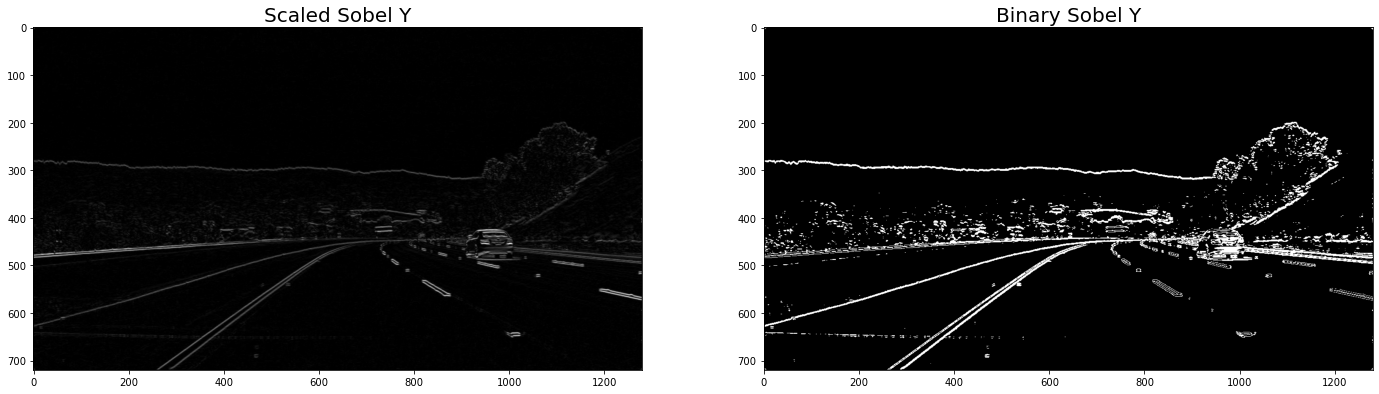

In [15]:
plt.figure(1, figsize=(24, 9))
ax1 = plt.subplot(121)
ax1.set_title("Scaled Sobel Y", fontsize = 20)
ax1.imshow(scaled_sobely, cmap = "gray")
ax2 = plt.subplot(122)
ax2.set_title("Binary Sobel Y", fontsize = 20)
ax2.imshow(sybinary, cmap = "gray")
#f, (ax1, ax2) = plt.subplots(2, 1)#figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(sobelx, cmap="gray")
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(sobely, cmap = "gray")
#ax2.set_title('Undistorted Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Applying Sobel
The procedure is now put into a function that can be used for later excercises.

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply cv2.Sobel()
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the output from cv2.Sobel()
    absolute = np.absolute(sobel)
    # Scale the result to an 8-bit range (0-255)
    scale = np.uint8(255*absolute/np.max(absolute))
    # Apply lower and upper thresholds
    binary_output = np.zeros_like(scale)
    binary_output[(scale >= np.min(thresh)) & (scale <= np.max(thresh))] = 1
    # Create binary_output
    return binary_output

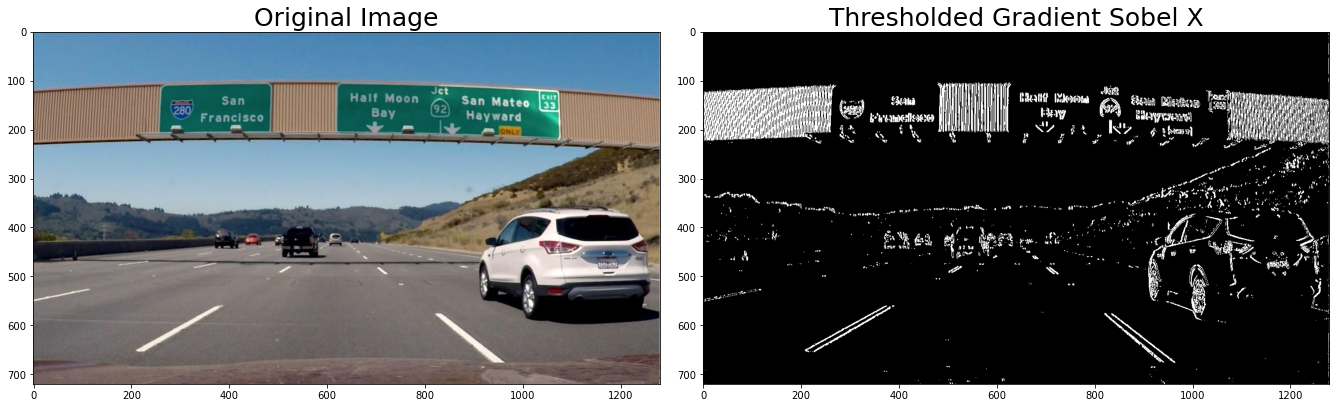

In [11]:
image = mpimg.imread('test_images/signs_vehicles_xygrad.png')
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh=(20, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient Sobel X', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Magnitude of the gradient
The goal of this exercise is to apply a threshold to the overall magnitude of the gradient in both x and y
The overall gradient considering x AND y is calculated as follows: $ abs\_sobelxy = \sqrt{(sobel_{x})^2 + (sobel_{y})^2} $

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255/np.max(magnitude) * magnitude)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= np.min(mag_thresh)) & (scaled <= np.max(mag_thresh))] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

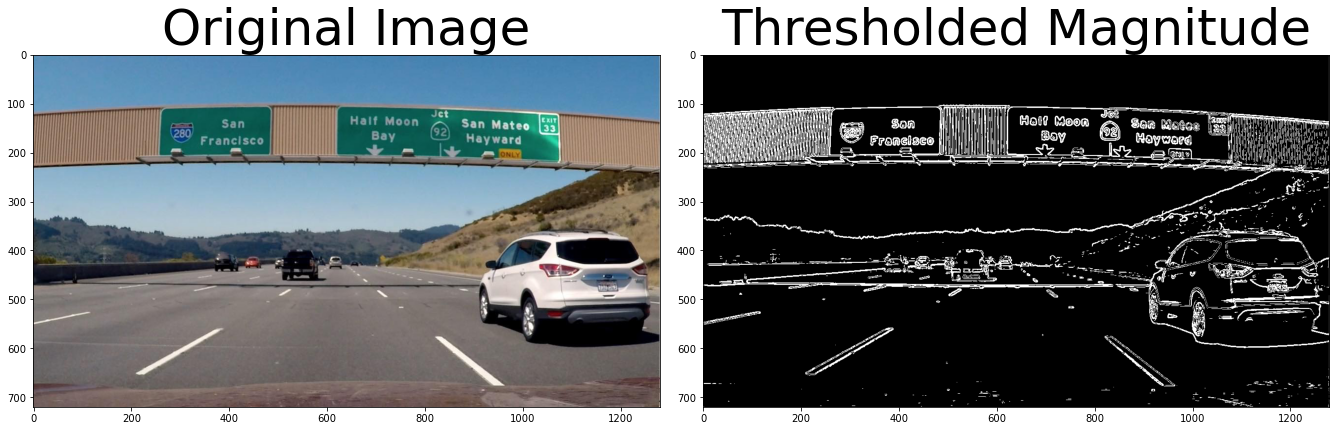

In [7]:
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Direction of the gradient
The direction of the gradient helps to identify edges that are of particular interest for the analysis.
The direction of the gradient is given by $ \arctan{(sobel_{y}\,/\,sobel_{x})} $ in radians, whereby 0 implies vertical line and $ \pm\,\pi\,/\,2 $ are horizontal lines

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= np.min(thresh)) & (direction <= np.max(thresh))] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

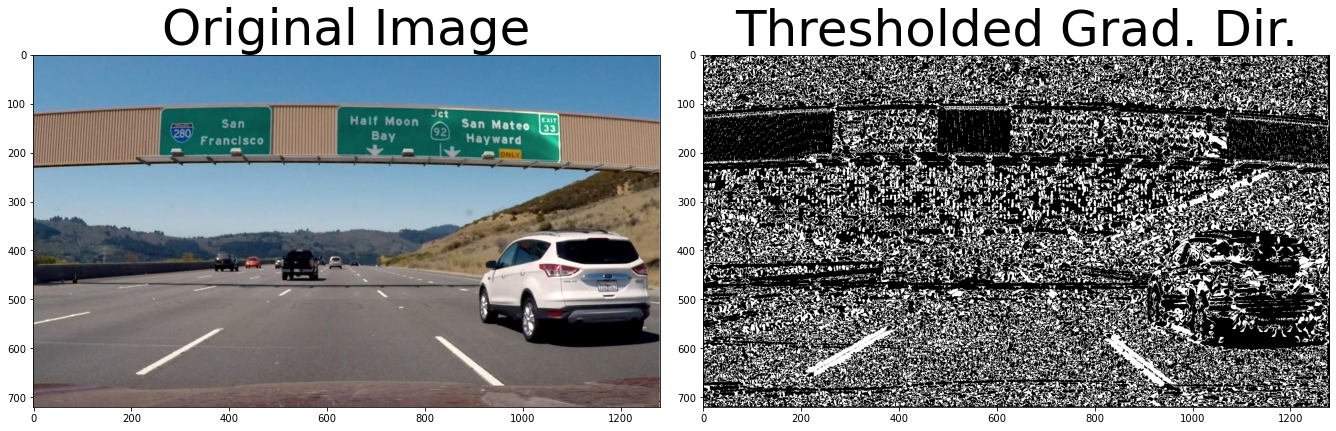

In [9]:
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining thresholds
Isolating the lane line pixels can be done by a combination of the various gradient measurements:
* X Gradient
* Y Gradient
* Magnitude
* Direction

In [16]:
def plot_results():
    # Plot the result
    plt.figure(1, figsize = (24,9))
    ax1 = plt.subplot(221)
    ax1.set_title('Sobel X', fontsize=20)
    ax1.imshow(gradx, cmap ="gray")
    ax2 = plt.subplot(222)
    ax2.set_title('Sobel Y', fontsize=20)
    ax2.imshow(grady, cmap ="gray")
    ax3 = plt.subplot(223)
    ax3.set_title('Magnitude', fontsize=20)
    ax3.imshow(mag_binary, cmap ="gray")
    ax4 = plt.subplot(224)
    ax4.set_title('Direction', fontsize=20)
    ax4.imshow(dir_binary, cmap ="gray")
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    plt.figure(2, figsize = (10,10))
    plt.imshow(combined, cmap ="gray")
    plt.title("Combined")

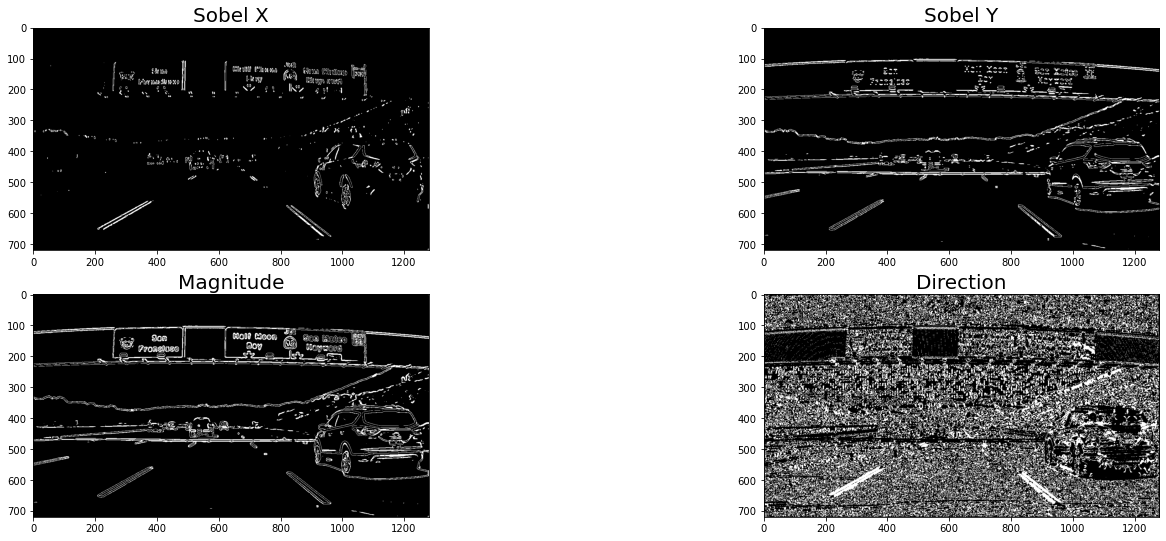

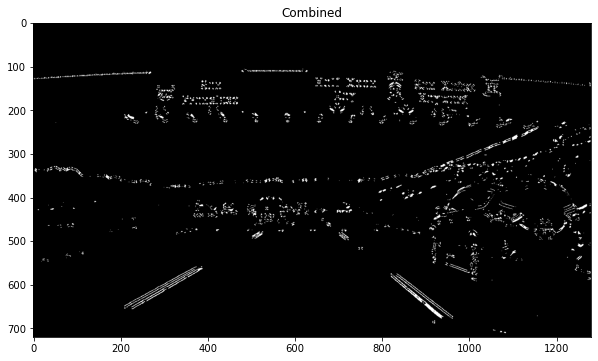

In [17]:
# Read image
image = mpimg.imread('test_images/signs_vehicles_xygrad.png')
# Choose a Sobel kernel size
ksize = 13 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(40, 80))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 80))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 80))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plot_results()

## Color Spaces and Color Thresholding
* RGB: Red, Green, Blue
* HSV: Hue, Saturation, Value
* HLS: Hue, Lightness, Saturation

In image analysis, mostly HSV and HLS are used.
* H has a range of 0 to 179 and represents the color independent of the brighntess
* S is a measurement of colourfulness
* L varies the most under different lightning conditions, whereas H and S stay fairly consitent in shadow or excessive brightness

A conversion from RBG to HLS color space can be performed using `hls = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)`

The different channels can be used to identify lane lines based on color thresholds.
* 

In [18]:
def save(name, image, c_map="gray"):
    path = 'colorspace_test_images/' + str(name) + '.jpg'
    mpimg.imsave(path, image, cmap = c_map)

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Read image
image = mpimg.imread('test_images/40_test1.jpg')

#apply different color space conversions and threshold techniques
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

#save("41_gray", gray)
#save("42_gray_binary", binary)

R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]
thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

#save("43_Red", R)
#save("44_Green", G)
#save("45_Blue", B)
#save("46_Red_binary", binary)

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

#save("47_Hue", H)
#save("48_Lightness", L)
#save("49_Saturation", S)

thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

#save("51_Saturation_binary", binary)

thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1

#save("50_Hue_binary", binary)


## HLS Color Threshold - Quiz
The task is to write a function that takes in an image, converts it to HLS and applies threshold values to the S-Channel for creating a binary picture.

In [20]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S > np.min(thresh)) & (S <= np.max(thresh))] = 1
    return binary_output

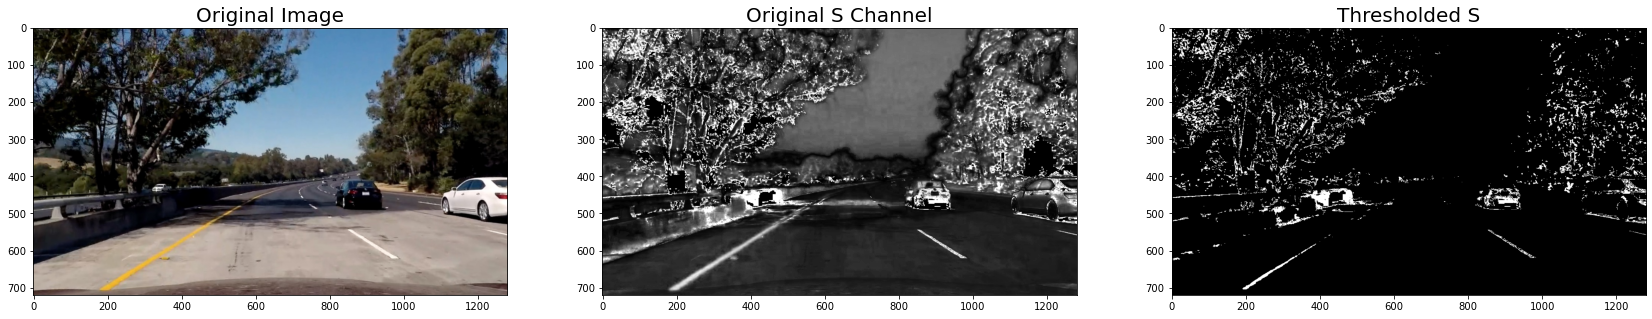

In [22]:
# Testing the hls_select function
image = mpimg.imread('test_images/60_bridge_shadow.jpg') 
hls_binary = hls_select(image, thresh=(205, 255))

# Comparison with orignal S Channel
S = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 4))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(S, cmap = "gray")
ax2.set_title('Original S Channel', fontsize=20)
ax3.imshow(hls_binary, cmap='gray')
ax3.set_title('Thresholded S', fontsize=20)
plt.subplots_adjust(top=0.963, bottom=0.037, left=0.028, right=0.992)
#thismanager = plt.get_current_fig_manager()
#thismanager.window.setGeometry(55, 115, 1833, 462)

In [ ]:
# Some useful code for adjusting the position of the figure Window
geom = thismanager.window.geometry()
x,y,dx,dy = geom.getRect()

## Combining Color and Gradient
The following code combines an Gradient (Sobel) with a S-Value threshold. The gradient binary and S binary can then combined in one image.

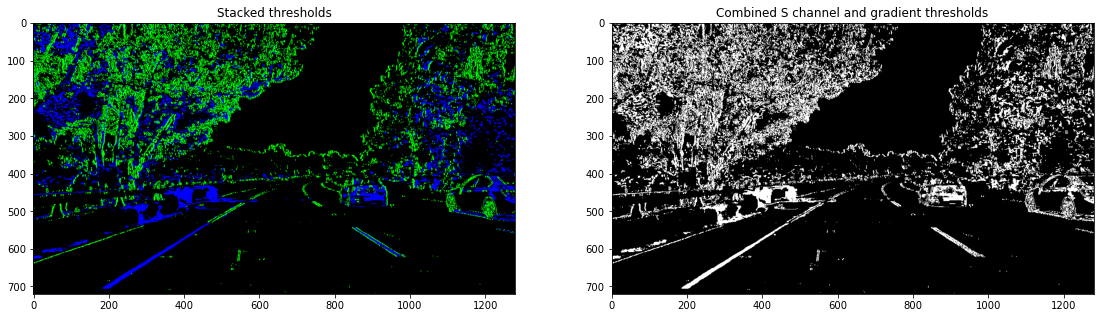

In [23]:
# Choose source image
img = mpimg.imread('test_images/60_bridge_shadow.jpg') 
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
plt.close('all')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,6))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [24]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary